<a href="https://colab.research.google.com/github/llawlaw23/Recommendation-System/blob/main/analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import gc
import re

In [ ]:
props1 = pd.read_csv("Datasets/item_properties_part1.1.csv")
props2 = pd.read_csv("Datasets/item_properties_part2.csv")
props = pd.concat([props1, props2])

### Data Understanding & Preprocessing

#### 1. Data Overview
- Brief description of the dataset ( size, number of features, number of columns and rows, and observations)
- Types of variables (numerical, categorical, datetime, etc.)
- Initial observations about the data (e.g., imbalance, missing data, outliers)

#### 2. Data Quality Checks
- Check for missing values and filling or dropping them.
- dropping columns.
- checking for outliers.

Mapping itemid to categoryid from Properties Dataset

In our dataset, the category of each item is stored within the properties table, specifically in rows where the property column has the value "categoryid". To extract a clean mapping of itemid → categoryid, we perform the following steps:

Filter the dataset to keep only rows where property == "categoryid".

Rename the value column to categoryid for clarity.

Convert the category IDs to integers to facilitate merging with other tables.


In [ ]:
props.head()

,timestamp,itemid,property,value
0,1435460400000,460429,categoryid,1338
1,1441508400000,206783,888,1116713 960601 n277.200
2,1439089200000,395014,400,n552.000 639502 n720.000 424566
3,1431226800000,59481,790,n15360.000
4,1431831600000,156781,917,828513


In [ ]:
main = props[props["property"].isin(["categoryid", "available"])]

In [ ]:
main = main.pivot_table(
    index = "itemid",
    columns = "property",
    values = "value",
    aggfunc = "first"
    ).reset_index()

In [ ]:
rest = props[~props["property"].isin(["categoryid", "available"])].copy()

In [ ]:
df_items = rest.merge(main, on = "itemid", how = "left")

In [ ]:
df_items.head()

,timestamp,itemid,property,value,available,categoryid
0,1441508400000,206783,888,1116713 960601 n277.200,0,942
1,1439089200000,395014,400,n552.000 639502 n720.000 424566,0,1135
2,1431226800000,59481,790,n15360.000,1,498
3,1431831600000,156781,917,828513,0,891
4,1434250800000,89534,213,1121373,0,1577


In [ ]:
# clean the value column and keep values with n attached to them and add them if they are multiple
def sum_n_values(text):
    nums = re.findall(r"n([\d\.]+)", str(text))
    nums = [float(x) for x in nums]
    return sum(nums) if nums else None

df_items["value_n"] = df_items["value"].apply(sum_n_values)

In [ ]:
df_items = df_items.drop(columns = ["value"])

In [ ]:
df_items.head()

,timestamp,itemid,property,available,categoryid,value_n
0,1441508400000,206783,888,0,942,277.2
1,1439089200000,395014,400,0,1135,1272.0
2,1431226800000,59481,790,1,498,15360.0
3,1431831600000,156781,917,0,891,NaN
4,1434250800000,89534,213,0,1577,NaN


In [ ]:
df_items.shape

(17984049, 6)

In [ ]:
df_items = df_items.dropna()

In [ ]:
df_items.shape

(5174013, 6)

In [ ]:
df_items.head(10)

,timestamp,itemid,property,available,categoryid,value_n
0,1441508400000,206783,888,0,942,277.2
1,1439089200000,395014,400,0,1135,1272.0
2,1431226800000,59481,790,1,498,15360.0
7,1434250800000,98113,451,0,48,48.0
8,1439089200000,450113,888,0,227,504.0
9,1435460400000,244127,400,0,589,1272.0
12,1434250800000,169055,790,1,1298,21000.0
13,1435460400000,178601,790,0,1378,5400.0
15,1437274800000,49337,0,0,1613,36.0
17,1439694000000,48696,566,1,959,480.0


In [ ]:
cols_to_int = ["categoryid", "available", "property"]
df_items[cols_to_int] = df_items[cols_to_int].astype("Int64")

In [ ]:
itemid_value = df_items.groupby("itemid")["value_n"].count()

In [ ]:
Q1 = itemid_value.quantile(0.25)
Q3 = itemid_value.quantile(0.75)
IQR = Q3 - Q1

In [ ]:
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

In [ ]:
outlier_itemid_value = itemid_value[(itemid_value < lower_bound) | (itemid_value > upper_bound)].index

In [ ]:
is_outlier = df_items["itemid"].isin(outlier_itemid_value)

In [ ]:
df_items = df_items[~is_outlier]

In [ ]:
df_items.shape

(4361433, 6)

In [ ]:
print(df_items.columns[df_items.columns.duplicated()])

Index([], dtype='object')


In [ ]:
df_items["timestamp"] = pd.to_datetime(df_items["timestamp"], unit = "ms")

In [ ]:
# saved the clean csv as an new file in the cleaned folder and delete the previous one
df_items.to_csv("df_items.csv", index = False)
del df_items; gc.collect()

636

In [ ]:
events = pd.read_csv("Datasets/events.csv")
cats = pd.read_csv("Datasets/category_tree.csv")

In [ ]:
events["timestamp"] = pd.to_datetime(events["timestamp"], unit = "ms")

In [ ]:
events.shape

(2756101, 5)

In [ ]:
events.isnull().sum()

,0
timestamp,0
visitorid,0
event,0
itemid,0
transactionid,2733644


In [ ]:
events = events.drop(columns = ["transactionid"])

In [ ]:
events.head()

,timestamp,visitorid,event,itemid
0,2015-06-02 05:02:12.117,257597,view,355908
1,2015-06-02 05:50:14.164,992329,view,248676
2,2015-06-02 05:13:19.827,111016,view,318965
3,2015-06-02 05:12:35.914,483717,view,253185
4,2015-06-02 05:02:17.106,951259,view,367447


In [ ]:
# map view = 1 add to chart = 3 and purchase  = 5, replacing it in the old column. dataype to int
event_weights = {"view": 1, "addtocart": 2, "transaction": 3}
events["event"] = events["event"].map(event_weights)

In [ ]:
# change datatype of event to int
events["event"] = events["event"].fillna(0).astype(int)

In [ ]:
events.head(20)

,timestamp,visitorid,event,itemid
0,2015-06-02 05:02:12.117,257597,1,355908
1,2015-06-02 05:50:14.164,992329,1,248676
2,2015-06-02 05:13:19.827,111016,1,318965
3,2015-06-02 05:12:35.914,483717,1,253185
4,2015-06-02 05:02:17.106,951259,1,367447
5,2015-06-02 05:48:06.234,972639,1,22556
6,2015-06-02 05:12:03.240,810725,1,443030
7,2015-06-02 05:34:51.897,794181,1,439202
8,2015-06-02 04:54:59.221,824915,1,428805
9,2015-06-02 05:00:04.592,339335,1,82389


In [ ]:
# min in visitorid
events["visitorid"].min()

0

checking for outliers and clearing them

In [ ]:
visitor_event = events.groupby("visitorid")["event"].count()

In [ ]:
# print in descending order
visitor_event = visitor_event.sort_values(ascending = False)

In [ ]:
visitor_event.head(20)

,event
visitorid,
1150086,7757
530559,4328
152963,3024
895999,2474
163561,2410
371606,2345
286616,2252
684514,2246
892013,2024


In [ ]:
Q1 = visitor_event.quantile(0.25)
Q3 = visitor_event.quantile(0.75)
IQR = Q3 - Q1

In [ ]:
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

In [ ]:
upper_bound

np.float64(3.5)

In [ ]:
lower_bound

np.float64(-0.5)

In [ ]:
outlier_visitor_ids = visitor_event[(visitor_event < lower_bound) | (visitor_event > upper_bound)].index

In [ ]:
is_outlier = events["visitorid"].isin(outlier_visitor_ids)

In [ ]:
print (is_outlier)

0          False
1           True
2          False
3          False
4          False
           ...  
2756096    False
2756097    False
2756098    False
2756099    False
2756100    False
Name: visitorid, Length: 2756101, dtype: bool


In [ ]:
events_F = events[~is_outlier]

In [ ]:
events_F.head()

,timestamp,visitorid,event,itemid
0,2015-06-02 05:02:12.117,257597,1,355908
2,2015-06-02 05:13:19.827,111016,1,318965
3,2015-06-02 05:12:35.914,483717,1,253185
4,2015-06-02 05:02:17.106,951259,1,367447
5,2015-06-02 05:48:06.234,972639,1,22556


In [ ]:
events_F.shape

(1652380, 4)

In [ ]:
cats.isnull().sum()

,0
categoryid,0
parentid,25


In [ ]:
cats = cats.dropna()

In [ ]:
# saved the clean csv as an new file in the cleaned folder and delete the previous one
events_F.to_csv("events_cleaned.csv", index = False)
del events_F; gc.collect()

In [ ]:
# saved the clean csv as an new file in the cleaned folder and delete the previous one
cats.to_csv("cats_cleaned.csv", index = False)
del cats; gc.collect()

In [1]:
import pandas as pd

In [5]:
# Loading cleaned csv files
events_cleaned = pd.read_csv("events_cleaned.csv")

cats_cleaned = pd.read_csv("cats_cleaned.csv")

df_items = pd.read_csv("df_items.csv")

In [6]:
print(events_cleaned.shape)
print(cats_cleaned.shape)
print(df_items.shape)

(25589, 4)
(1644, 2)
(23049, 6)


In [25]:
df_items.head()

,timestamp,itemid,property,available,categoryid,value_n
0,2015-09-06 03:00:00,206783.0,888.0,0.0,942.0,277.2
1,2015-08-09 03:00:00,395014.0,400.0,0.0,1135.0,1272.0
2,2015-05-10 03:00:00,59481.0,790.0,1.0,498.0,15360.0
3,2015-06-14 03:00:00,98113.0,451.0,0.0,48.0,48.0
4,2015-08-09 03:00:00,450113.0,888.0,0.0,227.0,504.0


In [3]:
df_items = df_items[["timestamp","itemid","property","value_n","categoryid","available"]]

In [ ]:
events_cleaned.head()

,timestamp,visitorid,event,itemid
0,2015-06-02 05:02:12.117,257597,1,355908
1,2015-06-02 05:13:19.827,111016,1,318965
2,2015-06-02 05:12:35.914,483717,1,253185
3,2015-06-02 05:02:17.106,951259,1,367447
4,2015-06-02 05:48:06.234,972639,1,22556


neural network for your recommendation system

In [23]:
import numpy as np
# import streamlit as st
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Concatenate, Dropout
from tensorflow.keras.optimizers import Adam

In [26]:
# Map users and items to integer indices
visitor_ids = events_cleaned["visitorid"].unique()
item_ids = df_items["itemid"].unique()

In [27]:
visitor_map = {v: i for i, v in enumerate(visitor_ids)}
item_map = {i: j for j, i in enumerate(item_ids)}

In [29]:
events_cleaned["visitor_idx"] = events_cleaned["visitorid"].map(visitor_map).fillna(-1).astype(int)
events_cleaned["item_idx"] = events_cleaned["itemid"].map(item_map).fillna(-1).astype(int)

In [30]:
# Use the event column directly as interaction target since i have map tthe items already
y = events_cleaned["event"].values.astype(np.float32)

In [31]:
num_users = len(visitor_map)
num_items = len(item_map)
embedding_size = 32

Final cleaning before neural network model

In [32]:
# Remove duplicate items
df_items_unique = df_items.drop_duplicates(subset = "itemid")

In [33]:
# Fill missing values
df_items_unique["categoryid"] = df_items_unique["categoryid"].fillna(-1).astype(int)
df_items_unique["available"] = df_items_unique["available"].fillna(0).astype(int)

/tmp/ipython-input-2669239481.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_items_unique["categoryid"] = df_items_unique["categoryid"].fillna(-1).astype(int)
/tmp/ipython-input-2669239481.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_items_unique["available"] = df_items_unique["available"].fillna(0).astype(int)


In [34]:
# Create item feature array aligned with item_map
item_feature_array = df_items_unique.set_index("itemid")[["categoryid", "available"]].reindex(item_ids).fillna(0).values

Tuning and designing neutral network

In [35]:
# user and item inputs
user_input = Input(shape = (1,), name = "user_input")
item_input = Input(shape = (1,), name = "item_input")
item_feature_input = Input(shape=(item_feature_array.shape[1],), name="item_feature_input")

In [36]:
# Embeddings
user_embedding = Embedding(input_dim = num_users, output_dim = embedding_size, name = "user_embedding")(user_input)
item_embedding = Embedding(input_dim = num_items, output_dim = embedding_size, name = "item_embedding")(item_input)


In [37]:
# Flatten embeddings
user_vec = Flatten()(user_embedding)
item_vec = Flatten()(item_embedding)

In [38]:
# Adding item features
# from categoryid and available columns
df_items["categoryid"] = df_items["categoryid"].fillna(-1).astype(int)
df_items["available"] = df_items["available"].fillna(0).astype(int)

In [39]:
# Concatenate embeddings and item features
x = Concatenate()([user_vec, item_vec, item_feature_input])

In [40]:
# Hidden layers
x = Dense(64, activation="relu")(x)
x = Dropout(0.3)(x)
x = Dense(32, activation="relu")(x)
x = Dropout(0.3)(x)

# Output layer: predict interaction score
output = Dense(1, activation="linear")(x)

In [41]:
# Build and compile model
model = Model(inputs=[user_input, item_input, item_feature_input], outputs = output)
model.compile(optimizer=Adam(learning_rate = 0.001), loss = "mse", metrics = ["mae"])

In [ ]:
# Prepare item feature inputs for each row
item_features_for_model = item_feature_array[events_cleaned["item_idx"].values]

history = model.fit(
    [events_cleaned["visitor_idx"].values,
     events_cleaned["item_idx"].values,
     item_features_for_model],
    y,
    epochs = 7,
    batch_size = 256,
    validation_split = 0.2
)

Epoch 1/10
2008/2959 ━━━━━━━━━━━━━━━━━━━━ 6:16 396ms/step - loss: 260.7056 - mae: 4.3017

### Data Visualization and Analysing Business Question

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

Q1
- How many unique visitors in a month?

In [ ]:
events_cleaned["timestamp"] = pd.to_datetime(events_cleaned["timestamp"])

In [ ]:
events_cleaned.head()

,timestamp,visitorid,event,itemid
0,2015-06-02 05:02:12.117,257597,1,355908
1,2015-06-02 05:13:19.827,111016,1,318965
2,2015-06-02 05:12:35.914,483717,1,253185
3,2015-06-02 05:02:17.106,951259,1,367447
4,2015-06-02 05:48:06.234,972639,1,22556


In [ ]:
events_cleaned["year_month"] = events_cleaned["timestamp"].dt.to_period("M")

In [ ]:
monthly_visitors = events_cleaned.groupby("year_month")["visitorid"].nunique().reset_index()

In [ ]:

print(monthly_visitors.head(10))

  year_month  visitorid
0    2015-05     274302
1    2015-06     276649
2    2015-07     337179
3    2015-08     279387
4    2015-09     155952


In [ ]:
monthly_visitors["year_month"] = monthly_visitors["year_month"].astype(str)

In [ ]:
color_map = {
    2015-05 : "#F564A9",
    2015-05 : "#98A1BC",
    2015-05 : "#DED3C4",
    2015-05 : "#264653",
    2015-05 : "#670D2F"
}

fig = px.bar(
    monthly_visitors,
    x = "year_month",
    y = "visitorid",
    color_discrete_map = color_map,
    title = "Unique Visitors per Month",
    labels = {"year_month": "Month", "visitorid": "Unique Visitors"},
    text = "visitorid"
)
fig.update_layout(
    legend_title_text = "Month",
    xaxis_title = "Month",
    yaxis = dict(
        showticklabels = False
    )
)

fig.show()

Q2
- What patterns exist in user-item interactions monthly?

In [ ]:
interactions_by_event = events_cleaned.groupby([events_cleaned["timestamp"].dt.date, "event"]).size().reset_index(name = "count")

In [ ]:

fig = px.line(interactions_by_event, x = "timestamp", y = "count", color = "event",
              title = "Interactions Over Time by Event Type",
              markers = True,
              color_discrete_sequence = px.colors.qualitative.Set2)

fig.update_layout(
    legend_title_text = "Month",
    xaxis_title = "Month",
    yaxis = dict(
        showticklabels = False
    )
)

fig.show()


Q3
- Most frequently interacted items?

In [ ]:
top_items = events_cleaned["itemid"].value_counts().head(5).reset_index()
top_items.columns = ["itemid", "event"]

In [ ]:

fig = px.bar(top_items, x = "itemid", y ="event",
             title = "Top 5 Most Interacted Items",
             color = "event",
             color_continuous_scale = "Viridis")

fig.update_layout(
    legend_title_text = "itemid",
    xaxis_title = "itemid",
    yaxis = dict(
        showticklabels = False
    )
)
fig.show()

Q4
- Top ten properties?

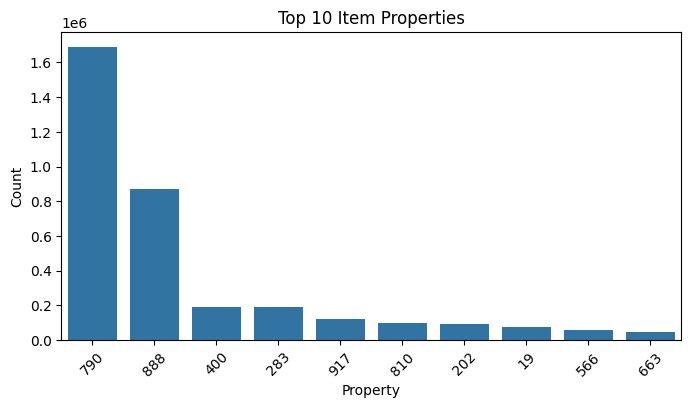

In [ ]:
top_props = props_cleaned["property"].value_counts().head(10)

plt.figure(figsize = (8, 4))
sns.barplot(x = top_props.index, y = top_props.values, order = top_props.index)
plt.xticks(rotation = 45)
plt.title("Top 10 Item Properties")
plt.xlabel("Property")
plt.ylabel("Count")
plt.show()

Q5
- Top categories by total interactions?

In [ ]:
category_counts = merged.groupby("categoryid")["itemid"].count().reset_index()
category_counts.columns = ["categoryid", "total_interactions"]

In [ ]:
category_counts = category_counts.sort_values("total_interactions", ascending = False).head(5)
category_counts["categoryid"] = pd.Categorical(category_counts["categoryid"], categories = category_counts["categoryid"], ordered = True)

In [ ]:
fig = px.bar(category_counts,
             x = "categoryid",
             y = "total_interactions",
             title = "Top 5 Categories by Total Interactions",
             labels = {"categoryid": "Category ID", "total_interactions": "Total Interactions"},
             color = "total_interactions")

fig.update_layout(legend_title_text = "Month",
                  xaxis_title = "Month",
)
fig.show()

NameError: name 'px' is not defined

Q6
- What are the most frequently interacted items across all visitors?

In [ ]:
item_counts = events_cleaned["itemid"].value_counts().reset_index()
item_counts.columns = ["itemid", "count"]

In [ ]:
fig = px.bar(item_counts.head(3), x = "itemid", y = "count",
             title = "Most Popular Items",
             labels = {"count":"Number of Interactions", "itemid":"Item ID"})
fig.update_layout(
    legend_title_text = "itemid",
    xaxis_title = "itemid",
    yaxis = dict(
        showticklabels = False
    )
)
fig.show()

Q7
- How do the types of events vary across items and visitors?

In [ ]:
event_counts = events_cleaned["event"].value_counts().reset_index()
event_counts.columns = ["event", "count"]

In [ ]:
color_map = {
    1: "#F564A9",
    3: "#98A1BC",
    5: "#DED3C4",
}

fig = px.pie(event_counts, names = "event", values = "count",
             title = "Distribution of Event Types",
             color_discrete_map = color_map,)

fig.update_layout(
    legend_title_text = "event",
    xaxis_title = "event",
)
fig.show()

In [ ]:
# STREAMLIT APP
# -------------------------------

st.title("Hybrid Recommendation System")

selected_user = st.number_input("Enter visitor ID:", value=int(events_cleaned["visitorid"].iloc[0]))
selected_item = st.number_input("Enter item ID:", value=int(df_items["itemid"].iloc[0]))

# Map inputs to indices
user_idx = visitor_map.get(selected_user, 0)
item_idx = item_map.get(selected_item, 0)
item_features_input = item_feature_array[item_idx].reshape(1, -1)

predicted_score = model.predict([np.array([user_idx]), np.array([item_idx]), item_features_input])
st.write(f"Predicted interaction score: {predicted_score[0][0]:.3f}")